In [2]:
import sys
import face_alignment
sys.path.append('..')
from align_faces import align_face
%load_ext autoreload
%autoreload 2

In [63]:
import tqdm
import glob
import torch
import numpy as np
import torchvision
from torchvision.utils import draw_keypoints
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as F
from lib.utils import show_imgs

def get_key_points(im, device='cuda'):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, 
                                    device=device)
    return fa.get_landmarks(im, return_bboxes=True)

imps = [
    '../tmp/lua_png/IMG_2730.png',
    '../tmp/lua_png/IMG_2750.png',
    # '../tmp/lua_png/IMG_0131.png',
    '../output/ddgs_images/jamal_crawford/125.jpg'
]
# imps = glob.glob('/Users/jiaxuanwang/Downloads/lua training set/lua_png/*.png')
imgs = []
lmks = []
bboxes = []
for imp in tqdm.tqdm(imps):
    im = torchvision.transforms.Resize((450, 450))(
        read_image(imp, ImageReadMode.RGB))
    lmk, lmk_socres, bbox = get_key_points(
        im if im.shape[2] == 3 else im.permute((1,2,0)),
        device='mps')
    if lmk == None: 
        import warnings
        print(f'no face detected in {imp}')
        warnings.warn('no face detected')
        continue
    lmks.append(lmk)
    imgs.append(
        draw_keypoints(
          im,
          torch.from_numpy(np.array(lmk)), colors="blue", radius=0)
      )
    bboxes.append(bbox)

show_imgs(imgs)
print([len(lmk) for lmk in lmks])

 67%|█████████████████████████████████████████████████████▎                          | 2/3 [00:02<00:01,  1.05s/it]


RuntimeError: Unsupported image file. Only jpeg and png are currently supported.

100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2218.62it/s]


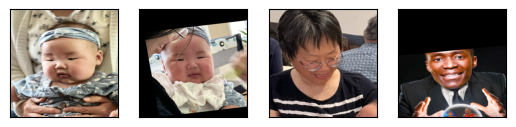

In [57]:
aligned_faces = []
for i, img in enumerate(tqdm.tqdm(imgs)):
    if i == 0:
        aligned_faces.append(img)
    else:
        aligned_faces.append(align_face(img, lmks[i][0], lmks[0][0]))

cadence = 4
for s in range(len(aligned_faces))[::cadence]:
    show_imgs(aligned_faces[s:s+cadence])

In [58]:
bboxes[-1]

[array([184.34418344,  -3.71459126, 283.0140748 , 168.95137858,
          0.9999516 ]),
 array([210.07773697, 317.93145162, 222.27789128, 334.90230352,
          0.97602749]),
 array([246.83084965, 305.67778015, 260.58870983, 330.86956024,
          0.93436009])]

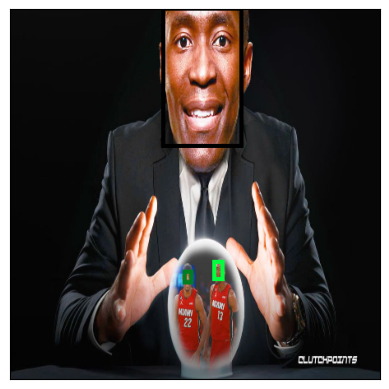

In [59]:
from torchvision.utils import draw_bounding_boxes
img_idx = 3
show_imgs(
    draw_bounding_boxes(imgs[img_idx], 
                        torch.from_numpy(np.array(
                            list(map(lambda b: b[:4], bboxes[img_idx]))
                        )), width=5)
)

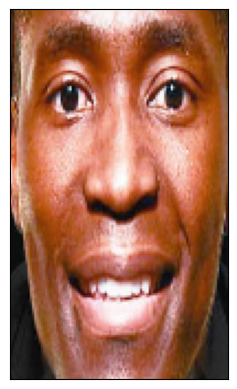

In [61]:
from lib.utils import crop_torch_im
img_idx = 3
show_imgs(crop_torch_im(imgs[img_idx], *bboxes[img_idx][0][:4]))

In [48]:
from deepface import DeepFace
from lib.utils import save_torch_image_tempfile
img_fn = save_torch_image_tempfile(
    crop_torch_im(imgs[0], *bboxes[img_idx][0][:4]), 
    suffix='.png')
img_fn2 = save_torch_image_tempfile(
    crop_torch_im(imgs[2], *bboxes[img_idx][0][:4]), 
    suffix='.png')
print(img_fn, img_fn2)
DeepFace.verify(img1_path = img_fn, 
                img2_path = img_fn2,
                 enforce_detection=False)

/var/folders/dl/4w963jp15vq_v3zlgtltlyl80000gn/T/tmp4thtf3gb.png /var/folders/dl/4w963jp15vq_v3zlgtltlyl80000gn/T/tmpuw75m_xx.png


{'verified': False,
 'distance': 0.4484628179772292,
 'threshold': 0.4,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 88, 'h': 90},
  'img2': {'x': 0, 'y': 0, 'w': 88, 'h': 90}},
 'time': 0.32}

In [31]:
DeepFace.verify(img1_path = read_image(imps[0], ImageReadMode.RGB).permute(1,2,0).numpy(), 
                img2_path = imps[2])

{'verified': True,
 'distance': 0.23758274344016206,
 'threshold': 0.4,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 1581, 'y': 2992, 'w': 82, 'h': 82},
  'img2': {'x': 1598, 'y': 2722, 'w': 97, 'h': 97}},
 'time': 0.96}

In [ ]:
plt.imshow()